<a href="https://colab.research.google.com/github/joke3547/Github-Colab-AIA/blob/main/AIA_face_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***資料讀取***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# !pip install kaggle

In [ ]:
# from google.colab import files
# files.upload()

In [ ]:
# !mkdir -p /root/.kaggle
# !cp /content/kaggle\ \(1\).json /root/.kaggle/kaggle.json
# !chmod 600 /root/.kaggle/kaggle.json

In [ ]:
# !kaggle competitions download -c aia-xt131-face-recognition

In [ ]:
# import zipfile
# with zipfile.ZipFile('aia-xt131-face-recognition.zip', 'r') as zip_ref:
#     zip_ref.extractall('data/')

# ***資料處理***

In [ ]:
import zipfile
import os

# 定义压缩文件的路径
zip_file_path = '/content/drive/MyDrive/AIA_Exercise/AIA-face-recognition/AIA_Face_Recognition.zip'

# 定义解压缩后的目标路径
extract_to_path = '/content'

# 创建目标文件夹（如果不存在）
os.makedirs(extract_to_path, exist_ok=True)

# 解压缩文件
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

print("文件已解压缩到:", extract_to_path)

文件已解压缩到: /content


# ***擷取臉部***

In [ ]:
# !pip install mtcnn
# from mtcnn import MTCNN
# import cv2
# import os

# # 创建 MTCNN 检测器实例
# detector = MTCNN()

# # 设置输入和输出文件夹路径
# input_folder = '/content/data/Test'
# output_folder = '/content/data/Test2'

# # 创建输出文件夹（如果不存在）
# if not os.path.exists(output_folder):
#     os.makedirs(output_folder)

# # 遍历输入文件夹中的图像文件
# for filename in os.listdir(input_folder):
#     # 拼接文件路径
#     input_path = os.path.join(input_folder, filename)
#     output_path = os.path.join(output_folder, filename)

#     # 使用 OpenCV 读取图像
#     image = cv2.imread(input_path)
#     image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#     # 使用 MTCNN 检测人脸并对齐
#     faces = detector.detect_faces(image_rgb)

#     # 添加人脸质量评估逻辑进行过滤
#     for face in faces:
#         bounding_box = face['box']
#         confidence = face['confidence']
#         x, y, w, h = bounding_box
#         face_image = image_rgb[y:y+h, x:x+w]  # 截取人脸区域

#         # 人脸质量评估逻辑：这里简单地通过置信度进行过滤，您可以根据需要调整阈值
#         if confidence >= 0.95:
#             # 保存处理后的图像
#             cv2.imwrite(output_path, cv2.cvtColor(face_image, cv2.COLOR_RGB2BGR))
#             break  # 一旦符合条件，跳出循环，不再处理当前图像

In [ ]:
# import os
# from zipfile import ZipFile

# # 要下载的文件夹路径
# folder_path = '/content/data/Test2'

# # 将文件夹压缩为 zip 文件
# zip_file_path = '/content/drive/MyDrive/AIA_Exercise/AIA-face-recognition/Test2.zip'  # 压缩后的 zip 文件路径
# with ZipFile(zip_file_path, 'w') as zipf:
#     for root, dirs, files in os.walk(folder_path):
#         for file in files:
#             zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), folder_path))

# # 如果要下载的文件夹不太大，也可以直接使用以下代码将其压缩并下载
# # !zip -r /content/folder.zip {folder_path}

# # 下载压缩后的 zip 文件
# # from google.colab import files
# # files.download(zip_file_path)

# ***準備訓練資料***

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# 設定參數
img_width, img_height = 160, 160  # 調整圖像尺寸
batch_size = 32

train_data_dir = '/content/AIA_Face_Recognition/Train2'
test_data_dir = '/content/AIA_Face_Recognition/Test2'

##資料增強
datagen = ImageDataGenerator(
    rescale=1. / 255,
    # horizontal_flip=True,
    # brightness_range=[1.2, 1.6],  # 可以調整亮度範圍
    validation_split=0.2  # 設定驗證資料的比例
)

# 使用subset參數
train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),  # 調整目標尺寸
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    classes=['Jennie','Jisoo','Lisa','Rose','Others']
)

validation_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),  # 調整目標尺寸
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    subset='validation',  # 'validation' subset
    classes=['Jennie','Jisoo','Lisa','Rose','Others']
)

# 讀取 sample.submission.csv 檔案
submission_df = pd.read_csv('/content/AIA_Face_Recognition/SampleSubmission.csv')
submission_df['filename'] = submission_df['filename'].apply(lambda x: f'{x}.jpg')
available_filenames = os.listdir(test_data_dir)
submission_df = submission_df[submission_df['filename'].isin(available_filenames)]
test_df = pd.DataFrame({
    'filename': submission_df['filename']
})

test_datagen = ImageDataGenerator(rescale=1./255)

# 使用 flow_from_dataframe 方法
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_data_dir,
    x_col='filename',
    y_col=None,
    target_size=(img_height, img_width),  # 調整目標尺寸
    color_mode='rgb',
    class_mode=None,  # 將 class_mode 設置為 None
    batch_size=batch_size,
    shuffle=False
)

Found 457 images belonging to 5 classes.
Found 111 images belonging to 5 classes.
Found 577 validated image filenames.


In [ ]:
test_df

,filename
0,wzsoflalzz.jpg
1,msjwpybvfo.jpg
2,wfmyruzsyc.jpg
3,yuobiuggur.jpg
4,njxpsmkijl.jpg
...,...
572,cmnhupznha.jpg
573,lirjbvolxj.jpg
574,fjxgoaavtf.jpg
575,apvlbradzl.jpg


In [ ]:
# from mtcnn import MTCNN
# import cv2
# import os

# # 设置输入和输出文件夹路径
# input_folder = '/content/data/Train/Jennie'
# output_folder = '/content/data/Train2/Jennie'

# # 创建输出文件夹（如果不存在）
# if not os.path.exists(output_folder):
#     os.makedirs(output_folder)

# # 创建 MTCNN 检测器实例
# detector = MTCNN()

# # 遍历输入文件夹中的图像文件
# for filename in os.listdir(input_folder):
#     # 拼接文件路径
#     input_path = os.path.join(input_folder, filename)
#     output_path = os.path.join(output_folder, filename)

#     # 使用 OpenCV 读取图像
#     image = cv2.imread(input_path)
#     image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#     # 使用 MTCNN 检测人脸并对齐
#     faces = detector.detect_faces(image_rgb)
#     for face in faces:
#         bounding_box = face['box']
#         x, y, w, h = bounding_box
#         face_image = image_rgb[y:y+h, x:x+w]  # 截取人脸区域
#         # 可以在此处对截取的人脸图像进行一些后续处理，如缩放、灰度化等

#         # 保存处理后的图像
#         cv2.imwrite(output_path, cv2.cvtColor(face_image, cv2.COLOR_RGB2BGR))


In [ ]:
# import os
# from zipfile import ZipFile

# # 要下载的文件夹路径
# folder_path = '/content/data/Train2/Jennie'

# # 将文件夹压缩为 zip 文件
# zip_file_path = '/content/Jennie.zip'  # 压缩后的 zip 文件路径
# with ZipFile(zip_file_path, 'w') as zipf:
#     for root, dirs, files in os.walk(folder_path):
#         for file in files:
#             zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), folder_path))

# # 如果要下载的文件夹不太大，也可以直接使用以下代码将其压缩并下载
# # !zip -r /content/folder.zip {folder_path}

# # 下载压缩后的 zip 文件
# from google.colab import files
# files.download(zip_file_path)

In [ ]:
def plot_from_generator(generator, num_images=8, rows=2, cols=4):
    """ 顯示從生成器中取得的圖片 """
    data_batch = next(generator)
    images, labels = data_batch[0], data_batch[1]

    plt.figure(figsize=(cols * 3, rows * 3))

    # 顯示圖片和對應的標籤
    for i in range(num_images):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i])

        # 找出標籤的索引
        label_index = int(labels[i].argmax())
        plt.title(f"Label: {label_index}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

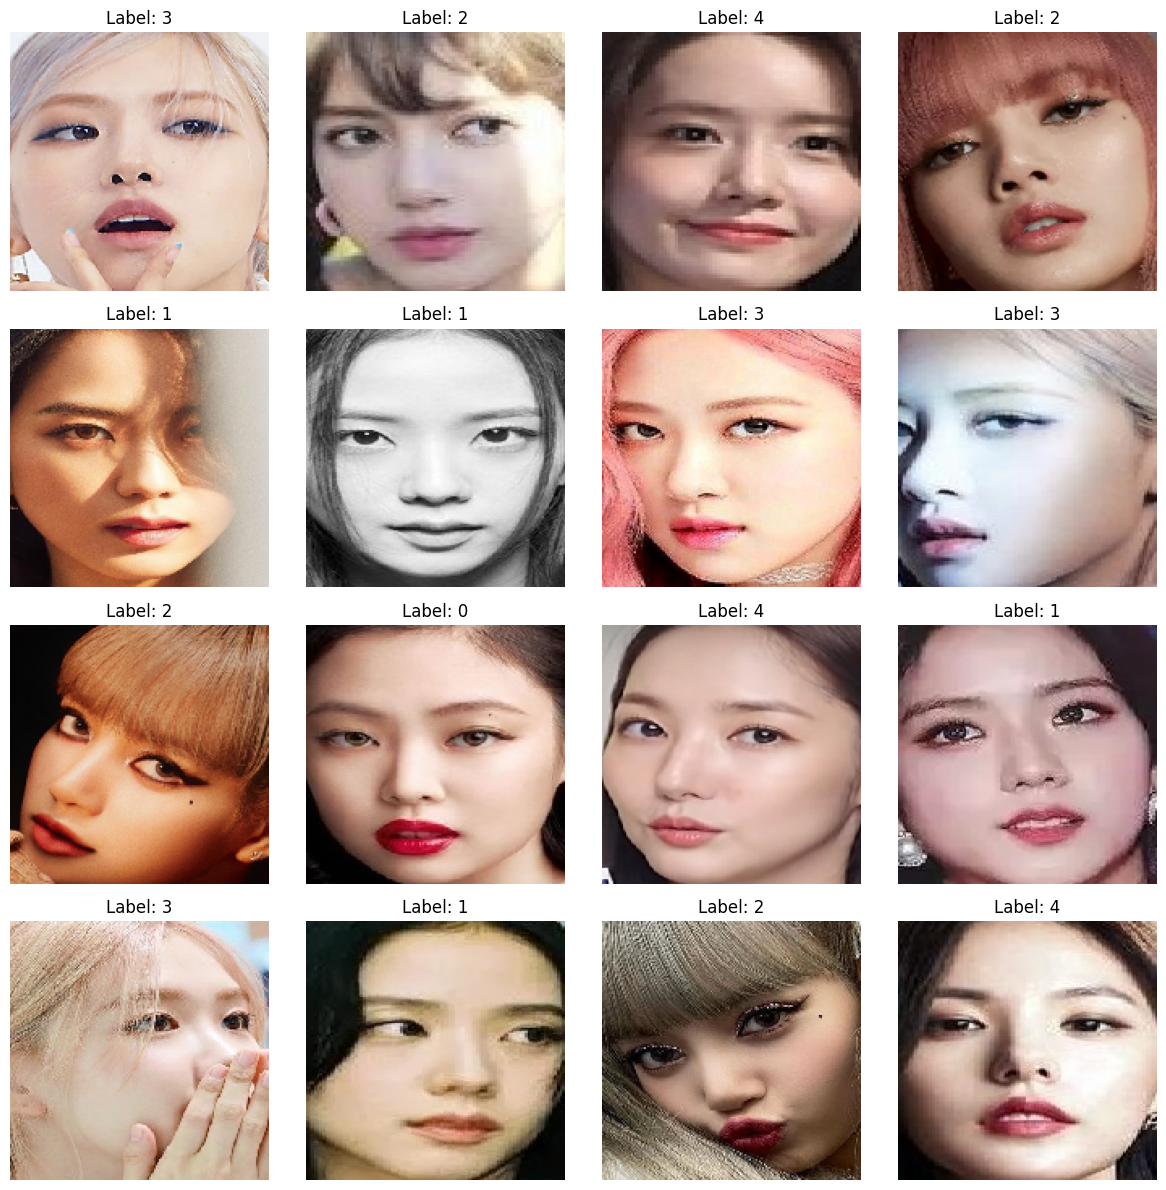

In [ ]:
plot_from_generator(train_generator, num_images=16, rows=4, cols=4)

# ***建立CNN模型***

In [ ]:
# 嘗試
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import (Conv2D, MaxPooling2D, BatchNormalization,
#                                      GlobalAveragePooling2D, Dense, Dropout, Activation)

# # 建立模型
# model = Sequential()

# # 第一組卷積層
# model.add(Conv2D(32, (3, 3), input_shape=(img_width, img_height, 3)))
# model.add(Activation('relu'))
# model.add(Conv2D(32, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# # 第二組卷積層
# model.add(Conv2D(64, (3, 3)))
# model.add(Activation('relu'))
# model.add(Conv2D(64, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# # 第三組卷積層
# model.add(Conv2D(128, (3, 3), padding='same'))
# model.add(Activation('relu'))
# model.add(Conv2D(128, (3, 3), padding='same'))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# # 第四組卷積層
# model.add(Conv2D(256, (3, 3), padding='same'))
# model.add(Activation('relu'))
# model.add(Conv2D(256, (3, 3), padding='same'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# # 全連接層
# model.add(GlobalAveragePooling2D())
# model.add(Dense(256))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))
# model.add(Dense(5))
# model.add(Activation('softmax'))

# # 編譯模型
# model.compile(loss='categorical_crossentropy',
#               optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
#               metrics=['accuracy'])

# # 輸出模型摘要
# model.summary()

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.regularizers import l2

# 載入預先訓練的InceptionV3模型
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# 新建模型
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),  # 加入正規化
    Dropout(0.5),  # 調整Dropout參數
    Dense(128, activation='relu'),  # 加入正規化
    Dropout(0.5),  # 調整Dropout參數
    Dense(64, activation='relu'),  # 加入正規化
    Dropout(0.5),  # 調整Dropout參數
    Dense(5, activation='softmax')  # 有5個類別  # 有5個類別
])

# # 解凍部分預先訓練的權重
# for layer in base_model.layers[:100]:
#     layer.trainable = False

# 編譯模型
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy'])

# 輸出模型摘要
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 256)               524544    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                      

# ***訓練***

In [ ]:
# 使用 ModelCheckpoint 回存最佳模型權重
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# 定義檔案路徑來保存模型的檢查點
checkpoint_path = "best_model_weights.h5"
# 創建一個回調函數來保存最佳模型
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
# 創建一個回調函數來實現早停
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stopping]   # 添加callbacks    # 將 ModelCheckpoint 回調添加到訓練過程中
)

# 加載保存的最佳模型權重
model.load_weights('best_model_weights.h5')

Epoch 1/100
15/15 [==============================] - ETA: 0s - loss: 1.9305 - accuracy: 0.1882
Epoch 1: val_accuracy improved from -inf to 0.21622, saving model to best_model_weights.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


15/15 [==============================] - 34s 415ms/step - loss: 1.9305 - accuracy: 0.1882 - val_loss: 1.7190 - val_accuracy: 0.2162
Epoch 2/100
15/15 [==============================] - ETA: 0s - loss: 1.7945 - accuracy: 0.2276
Epoch 2: val_accuracy did not improve from 0.21622
15/15 [==============================] - 2s 153ms/step - loss: 1.7945 - accuracy: 0.2276 - val_loss: 1.6875 - val_accuracy: 0.2162
Epoch 3/100
15/15 [==============================] - ETA: 0s - loss: 1.7034 - accuracy: 0.2451
Epoch 3: val_accuracy did not improve from 0.21622
15/15 [==============================] - 2s 153ms/step - loss: 1.7034 - accuracy: 0.2451 - val_loss: 1.6660 - val_accuracy: 0.1982
Epoch 4/100
15/15 [==============================] - ETA: 0s - loss: 1.5627 - accuracy: 0.3173
Epoch 4: val_accuracy did not improve from 0.21622
15/15 [==============================] - 2s 144ms/step - loss: 1.5627 - accuracy: 0.3173 - val_loss: 1.7789 - val_accuracy: 0.1982
Epoch 5/100
15/15 [==================

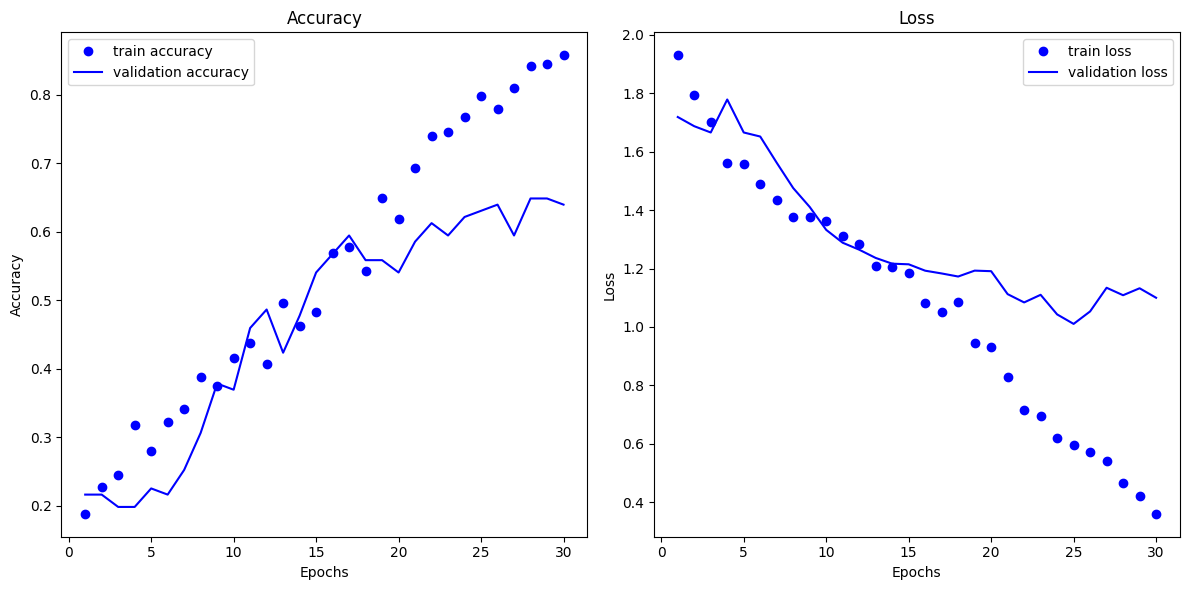

In [ ]:
# 獲取歷史數據
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

# Accuracy 曲線
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, 'bo', label='train accuracy')
plt.plot(epochs_range, val_acc, 'b', label='validation accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss 曲線
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, 'bo', label='train loss')
plt.plot(epochs_range, val_loss, 'b', label='validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

4/4 [==============================] - 2s 61ms/step


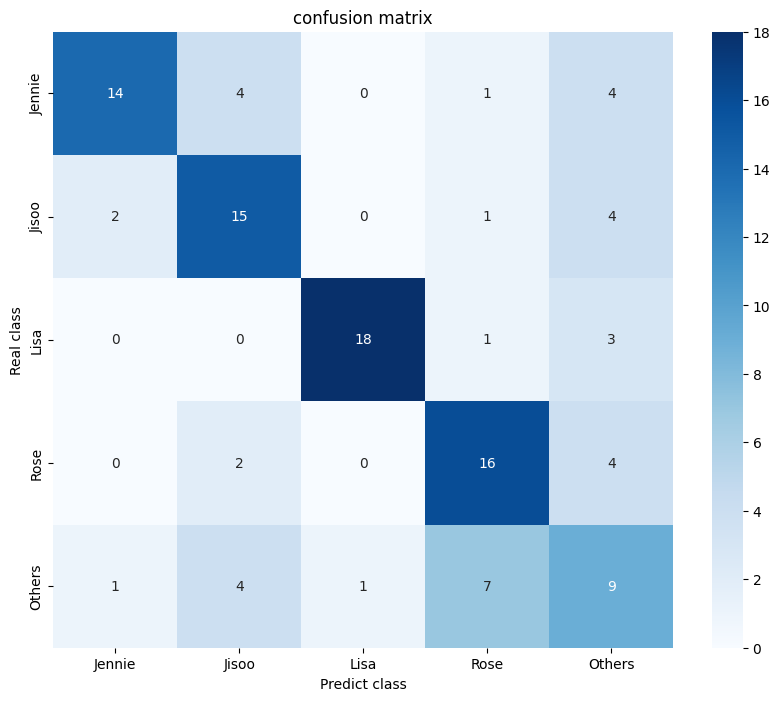

In [ ]:
from sklearn.metrics import confusion_matrix

# 1. 使用模型進行預測
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # 取得預測的類別索引
y_true = validation_generator.classes  # 取得真實的類別索引

# 2. 產生混淆矩陣
cm = confusion_matrix(y_true, y_pred_classes)

# 3. 繪製混淆矩陣
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=validation_generator.class_indices, yticklabels=validation_generator.class_indices)
plt.ylabel('Real class')
plt.xlabel('Predict class')
plt.title('confusion matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# 1. 使用模型在驗證集上進行預測
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# 獲取真實的標籤
y_true = validation_generator.classes

# 2. 使用 scikit-learn 計算 precision 和 recall
report = classification_report(y_true, y_pred_classes, target_names=list(validation_generator.class_indices.keys()))

print(report)

4/4 [==============================] - 0s 45ms/step
              precision    recall  f1-score   support

      Jennie       0.82      0.61      0.70        23
       Jisoo       0.60      0.68      0.64        22
        Lisa       0.95      0.82      0.88        22
        Rose       0.62      0.73      0.67        22
      Others       0.38      0.41      0.39        22

    accuracy                           0.65       111
   macro avg       0.67      0.65      0.65       111
weighted avg       0.67      0.65      0.66       111



In [ ]:
filenames = [filename.split('/')[-1] for filename in test_generator.filenames]  # 只取文件名，去除路徑
predictions = model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

19/19 [==============================] - 4s 123ms/step


In [ ]:
predicted_classes

array([3, 3, 4, 1, 4, 2, 0, 4, 0, 3, 1, 3, 1, 1, 1, 4, 4, 3, 3, 2, 0, 2,
       2, 4, 0, 1, 3, 4, 3, 4, 4, 1, 0, 1, 2, 3, 2, 2, 3, 1, 1, 3, 3, 3,
       4, 4, 0, 3, 3, 2, 4, 2, 0, 4, 2, 3, 4, 3, 4, 2, 3, 4, 2, 1, 4, 2,
       3, 3, 2, 3, 2, 4, 1, 1, 3, 2, 1, 3, 2, 3, 0, 3, 2, 2, 4, 1, 3, 2,
       1, 1, 1, 1, 0, 3, 3, 1, 4, 3, 2, 3, 2, 1, 4, 1, 4, 2, 3, 2, 0, 0,
       3, 3, 2, 3, 3, 0, 1, 0, 1, 0, 1, 4, 1, 2, 3, 4, 2, 4, 4, 3, 3, 0,
       0, 2, 3, 2, 4, 3, 4, 4, 2, 2, 4, 4, 0, 2, 4, 3, 0, 2, 0, 0, 0, 4,
       2, 0, 3, 4, 4, 4, 2, 3, 0, 3, 2, 0, 0, 3, 0, 4, 3, 1, 3, 1, 2, 3,
       0, 2, 3, 3, 1, 4, 4, 1, 3, 4, 4, 3, 4, 3, 2, 4, 3, 3, 2, 2, 1, 2,
       1, 1, 0, 0, 3, 0, 0, 4, 0, 4, 4, 3, 2, 2, 0, 3, 2, 0, 0, 0, 0, 3,
       3, 3, 2, 0, 4, 2, 2, 2, 3, 0, 2, 3, 1, 3, 1, 1, 4, 3, 1, 1, 2, 3,
       0, 3, 0, 0, 3, 1, 3, 1, 1, 3, 2, 1, 4, 4, 4, 3, 1, 3, 3, 3, 3, 3,
       4, 2, 0, 1, 2, 2, 3, 4, 3, 4, 1, 1, 2, 2, 2, 3, 0, 4, 3, 0, 0, 3,
       3, 2, 4, 2, 4, 4, 0, 2, 2, 4, 2, 1, 2, 3, 0,

In [ ]:
submission_df = pd.read_csv('/content/AIA_Face_Recognition/SampleSubmission.csv')
submission_df = submission_df.set_index('filename')   # 確保這裡的列名和 CSV 檔案中的一致
submission_df = submission_df.reindex(filenames)  # 重新索引以匹配 filenames 的順序
submission_df = submission_df.reset_index()

In [ ]:
submission_df

,filename,label
0,wzsoflalzz.jpg,NaN
1,msjwpybvfo.jpg,NaN
2,wfmyruzsyc.jpg,NaN
3,yuobiuggur.jpg,NaN
4,njxpsmkijl.jpg,NaN
...,...,...
572,cmnhupznha.jpg,NaN
573,lirjbvolxj.jpg,NaN
574,fjxgoaavtf.jpg,NaN
575,apvlbradzl.jpg,NaN


In [ ]:
submission_df['filename'] = submission_df['filename'].str.replace('.jpg', '', regex=False)
submission_df['label'] = predicted_classes  # 確保這裡的 'class' 是你的預測類別

In [ ]:
submission_df

,filename,label
0,wzsoflalzz,3
1,msjwpybvfo,3
2,wfmyruzsyc,4
3,yuobiuggur,1
4,njxpsmkijl,4
...,...,...
572,cmnhupznha,0
573,lirjbvolxj,1
574,fjxgoaavtf,4
575,apvlbradzl,3


In [ ]:
submission_df.to_csv('/content/submission1.csv', index=False)  # 確保路徑正確